In [2]:
import os
import numpy as np
import matplotlib.pyplot as plt

In [3]:
import tensorflow as tf
import tensorflow_datasets as tfds

div2k_data = tfds.image.Div2k(config="bicubic_x4")
div2k_data.download_and_prepare()

AUTOTUNE = tf.data.AUTOTUNE

In [4]:
train = div2k_data.as_dataset(split="train", as_supervised=True)
train_cache = train.cache()

val = div2k_data.as_dataset(split="validation", as_supervised=True)
val_cache = val.cache()


In [5]:
from tensorflow.io import FixedLenFeature, parse_single_example, parse_tensor
from tensorflow.image import flip_left_right, rot90

def random_crop(lrImage, hrImage, hrCropSize=96, scale=4):
	# calculate the low resolution image crop size and image shape
	lrCropSize = hrCropSize // scale
	lrImageShape = tf.shape(lrImage)[:2]

	# calculate the low resolution image width and height offsets
	lrW = tf.random.uniform(shape=(),
		maxval=lrImageShape[1] - lrCropSize + 1, dtype=tf.int32)
	lrH = tf.random.uniform(shape=(),
		maxval=lrImageShape[0] - lrCropSize + 1, dtype=tf.int32)
 
	# calculate the high resolution image width and height
	hrW = lrW * scale
	hrH = lrH * scale

	# crop the low and high resolution images
	lrImageCropped = tf.slice(lrImage, [lrH, lrW, 0], 
		[(lrCropSize), (lrCropSize), 3])
	hrImageCropped = tf.slice(hrImage, [hrH, hrW, 0],
		[(hrCropSize), (hrCropSize), 3])
 
	# return the cropped low and high resolution images
	return (lrImageCropped, hrImageCropped)

In [6]:
def get_center_crop(lrImage, hrImage, hrCropSize=96, scale=4):
	# calculate the low resolution image crop size and image shape
	lrCropSize = hrCropSize // scale
	lrImageShape = tf.shape(lrImage)[:2]

	# calculate the low resolution image width and height
	lrW = lrImageShape[1] // 2
	lrH = lrImageShape[0] // 2

	# calculate the high resolution image width and height
	hrW = lrW * scale
	hrH = lrH * scale

	# crop the low and high resolution images
	lrImageCropped = tf.slice(lrImage, [lrH - (lrCropSize // 2),
		lrW - (lrCropSize // 2), 0], [lrCropSize, lrCropSize, 3])
	hrImageCropped = tf.slice(hrImage, [hrH - (hrCropSize // 2),
		hrW - (hrCropSize // 2), 0], [hrCropSize, hrCropSize, 3])
 
	# return the cropped low and high resolution images
	return (lrImageCropped, hrImageCropped)

In [7]:
def random_flip(lrImage, hrImage):
	# calculate a random chance for flip
	flipProb = tf.random.uniform(shape=(), maxval=1)
	(lrImage, hrImage) = tf.cond(flipProb < 0.5,
		lambda: (lrImage, hrImage),
		lambda: (flip_left_right(lrImage), flip_left_right(hrImage)))
	
	# return the randomly flipped low and high resolution images
	return (lrImage, hrImage)

In [8]:
def random_rotate(lrImage, hrImage):
	# randomly generate the number of 90 degree rotations
	n = tf.random.uniform(shape=(), maxval=4, dtype=tf.int32)
 
	# rotate the low and high resolution images
	lrImage = rot90(lrImage, n)
	hrImage = rot90(hrImage, n)
 
	# return the randomly rotated images
	return (lrImage, hrImage)

In [9]:
def dataset_object(dataset_cache, batch_size, training=True):
	ds = dataset_cache
	ds = ds.map(
			lambda lowres, highres: random_crop(lowres, highres, scale=4),
			num_parallel_calls=AUTOTUNE,
	)

	if training:
		ds = ds.map(random_crop, num_parallel_calls=AUTOTUNE)
		ds = ds.map(random_flip, num_parallel_calls=AUTOTUNE)
		ds = ds.map(random_rotate, num_parallel_calls=AUTOTUNE)
	else:
		ds = ds.map(get_center_crop, num_parallel_calls=AUTOTUNE)
	
	# Batching Data
	ds = ds.batch(batch_size)

	if training:
			# Repeating Data, so that cardinality if dataset becomes infinte
			ds = ds.repeat()
	 
	# prefetching allows later images to be prepared while the current image is being processed
	ds = ds.prefetch(buffer_size=AUTOTUNE)
	return ds


In [12]:
batch_size = 64

train_ds = dataset_object(train_cache, batch_size, training=True)
val_ds = dataset_object(val_cache, batch_size, training=False)

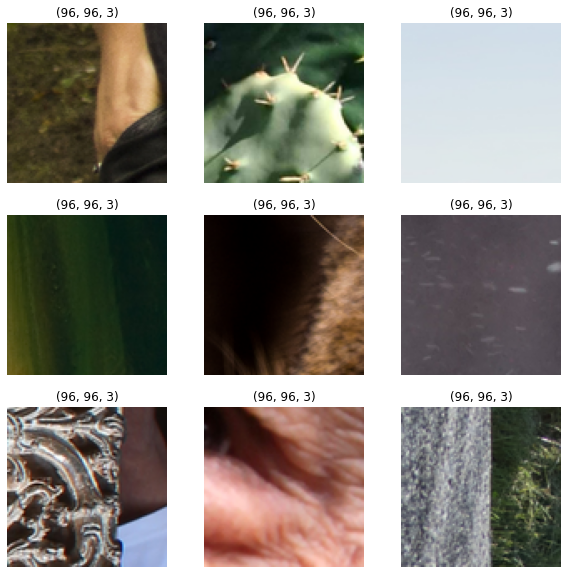

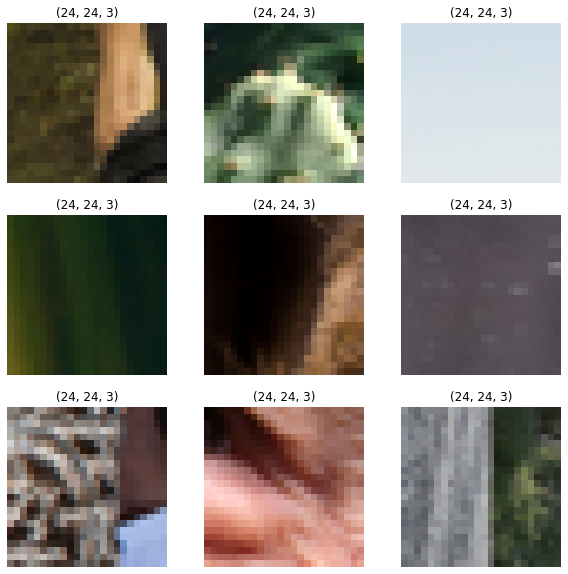

In [13]:
lowres, highres = next(iter(train_ds))

# Hight Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(highres[i].numpy().astype("uint8"))
    plt.title(highres[i].shape)
    plt.axis("off")

# Low Resolution Images
plt.figure(figsize=(10, 10))
for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    plt.imshow(lowres[i].numpy().astype("uint8"))
    plt.title(lowres[i].shape)
    plt.axis("off")


def PSNR(super_resolution, high_resolution):
    """Compute the peak signal-to-noise ratio, measures quality of image."""
    # Max value of pixel is 255
    psnr_value = tf.image.psnr(high_resolution, super_resolution, max_val=255)[0]
    return psnr_value


In [14]:
from keras.layers import BatchNormalization, GlobalAvgPool2D, LeakyReLU, Lambda
from keras.layers import Conv2D, Dense, Add, Rescaling
from tensorflow.nn import depth_to_space
from keras import Model
from keras import Input

class ESRGAN(object):

	def generator(scaling_factor, feature_maps, residual_blocks,
			leaky_alpha, residual_scalar):
   
		input_layer = Input((None, None, 3))
		xIn = Rescaling(scale=1.0/255, offset=0.0)(input_layer)
  
		xIn = Conv2D(filters=feature_maps, kernel_size=9, padding="same")(xIn)
		xIn = LeakyReLU(leaky_alpha)(xIn)
  
  	# construct the residual in residual block
		x = Conv2D(filters=feature_maps, kernel_size=3, padding="same")(xIn)
		x1 = LeakyReLU(leaky_alpha)(x)
		x1 = Add()([xIn, x1])
	
		x = Conv2D(filters=feature_maps, kernel_size=3, padding="same")(x1)
		x2 = LeakyReLU(leaky_alpha)(x)
		x2 = Add()([x1, x2])
	
		x = Conv2D(filters=feature_maps, kernel_size=3, padding="same")(x2)
		x3 = LeakyReLU(leaky_alpha)(x)
		x3 = Add()([x2, x3])
	
		x = Conv2D(filters=feature_maps, kernel_size=3, padding="same")(x3)
		x4 = LeakyReLU(leaky_alpha)(x)
		x4 = Add()([x3, x4])
		x4 = Conv2D(filters=feature_maps, kernel_size=3, padding="same")(x4)
	
		xSkip = Add()([xIn, x4])
  
		# scale the residual outputs with a scalar between [0,1]
		xSkip = Lambda(lambda x: x * residual_scalar)(xSkip)
  
  	# create a number of residual in residual blocks
		for blockId in range(residual_blocks-1):
			x = Conv2D(filters=feature_maps, kernel_size=3, padding="same")(xSkip)
			x1 = LeakyReLU(leaky_alpha)(x)
			x1 = Add()([xSkip, x1])
	 
			x = Conv2D(filters=feature_maps, kernel_size=3, padding="same")(x1)
			x2 = LeakyReLU(leaky_alpha)(x)
			x2 = Add()([x1, x2])
	 
			x = Conv2D(filters=feature_maps, kernel_size=3, padding="same")(x2)
			x3 = LeakyReLU(leaky_alpha)(x)
			x3 = Add()([x2, x3])
	 
			x = Conv2D(filters=feature_maps, kernel_size=3, padding="same")(x3)
			x4 = LeakyReLU(leaky_alpha)(x)
			x4 = Add()([x3, x4])
			x4 = Conv2D(filters=feature_maps, kernel_size=3, padding="same")(x4)
	 
			xSkip = Add()([xSkip, x4])
			xSkip = Lambda(lambda x: x * residual_scalar)(xSkip)

		x = Conv2D(filters=feature_maps, kernel_size=3, padding="same")(xSkip)
		x = Add()([xIn, x])
  
		# upscale the image with pixel shuffle
		x = Conv2D(filters=feature_maps * (scaling_factor // 2), kernel_size=3, 
		           padding="same")(x)
		x = tf.nn.depth_to_space(x, 2)
		x = LeakyReLU(leaky_alpha)(x)
  
		# upscale the image with pixel shuffle
		x = Conv2D(filters=feature_maps, kernel_size=3, padding="same")(x)
		x = tf.nn.depth_to_space(x, 2)
		x = LeakyReLU(leaky_alpha)(x)
  
		x = Conv2D(filters=3, kernel_size=9, padding="same", activation="tanh")(x)
		output_layer = Rescaling(scale=127.5, offset=127.5)(x)
  
		generator = Model(inputs=input_layer, outputs=output_layer)
  
		return generator

	def discriminator(feature_maps, leaky_alpha, disc_blocks):
		input_layer = Input((None, None, 3))
	
		x = Rescaling(scale=1.0/127.5, offset=-1)(input_layer)
		x = Conv2D(filters=feature_maps, kernel_size=3, padding="same")(x)
		x = LeakyReLU(leaky_alpha)(x)
		
		x = Conv2D(filters=feature_maps, kernel_size=3, padding="same")(x)
		x = BatchNormalization()(x)
		x = LeakyReLU(leaky_alpha)(x)
  
  	# create a downsample conv kernel config
		downConvConf = {
			"strides": (2,2),
			"padding": "same",
		}

		# create a number of discriminator blocks
		for i in range(1, disc_blocks):
    
			x = Conv2D(filters=feature_maps * (2 ** i), kernel_size=3, **downConvConf)(x)
			x = BatchNormalization()(x)
			x = LeakyReLU(leaky_alpha)(x)
   
			x = Conv2D(filters=feature_maps * (2 ** i), kernel_size=3, padding="same")(x)
			x = BatchNormalization()(x)
			x = LeakyReLU(leaky_alpha)(x)
   
		x = GlobalAvgPool2D()(x)
		x = LeakyReLU(leaky_alpha)(x)
		output_layer = Dense(1, activation="sigmoid")(x)
  
		discriminator = Model(inputs=input_layer, outputs=output_layer)
  
		return discriminator

In [28]:
from keras.losses import MeanSquaredError, BinaryCrossentropy
from tensorflow import reduce_mean
from tensorflow.keras.losses import Reduction

class Losses:
  def __init__(self, num_replicas):
    self.num_replicas = num_replicas

  def bce_loss(self, real, pred):
    bce = BinaryCrossentropy(reduction=Reduction.NONE)
    loss = bce(real, pred)
    loss = reduce_mean(loss) * (1. / self.num_replicas)
    return loss
    
  def mse_loss(self, real, pred):
    mse = MeanSquaredError(reduction=Reduction.NONE)
    loss = mse(real, pred)
    loss = reduce_mean(loss) * (1. / self.num_replicas)
    return loss

In [29]:
from tensorflow import concat, zeros, GradientTape, ones
from keras.activations import sigmoid
from tensorflow.math import reduce_mean

class ESRGANTraining(Model):
  def __init__(self, generator, discriminator, vgg, batch_size):
    super().__init__()
    self.generator = generator
    self.discriminator = discriminator
    self.vgg = vgg
    self.batch_size = batch_size

  def compile(self, generator_optimizer, discriminator_optimizer, bce_loss, mse_loss):
    super().compile()
    self.generator_optimizer = generator_optimizer
    self.discriminator_optimizer = discriminator_optimizer

    self.bce_loss = bce_loss
    self.mse_loss = mse_loss

  def train_step(self, images):
    (lr_images, hr_images) = images
    lr_images = tf.cast(lr_images, tf.float32)
    hr_images = tf.cast(hr_images, tf.float32)
  
		# generate super resolution images
    sr_images = self.generator(lr_images)
  
		# combine them with real images
    combined_images = concat([sr_images, hr_images], axis=0)
  
		# assemble labels discriminating real from fake images where
		# label 0 is for predicted images and 1 is for original high
		# resolution images
    labels = concat([zeros((self.batch_size, 1)), ones((self.batch_size, 1))], axis=0)
    
    with GradientTape() as tape:
      raw_preds = self.discriminator(combined_images)
      raw_fake = raw_preds[:self.batch_size]
      raw_real = raw_preds[self.batch_size:]

      predFake = sigmoid(raw_fake - reduce_mean(raw_real)) 
      predReal = sigmoid(raw_real - reduce_mean(raw_fake))
			
      predictions = concat([predFake, predReal], axis=0)
      d_loss = self.bce_loss(labels, predictions)
		
		# compute the gradients
    grads = tape.gradient(d_loss, self.discriminator.trainable_variables)
		
    self.discriminator_optimizer.apply_gradients(zip(grads, 
                                                     self.discriminator.trainable_variables))
		# generate misleading labels
    miss_leading_labels = ones((self.batch_size, 1))

    # train the generator (note that we should *not* update the weights of the discriminator)
    with GradientTape() as tape:
			# generate fake images
      fake_images = self.generator(lr_images)
			
			# calculate predictions
      raw_preds = self.discriminator(fake_images)
      real_preds = self.discriminator(hr_images)
      relativistic_preds = raw_preds - reduce_mean(real_preds)
      predictions = sigmoid(relativistic_preds)
			
			# compute the discriminator predictions on the fake images
      g_loss = self.bce_loss(miss_leading_labels, predictions)
			
			# compute the pixel loss
      pixel_loss = self.mse_loss(hr_images, fake_images)

			# compute the normalized vgg outputs
      sr_VGG = tf.keras.applications.vgg19.preprocess_input(fake_images)
      sr_VGG = self.vgg(sr_VGG) / 12.75
      hr_VGG = tf.keras.applications.vgg19.preprocess_input(hr_images)
      hr_VGG = self.vgg(hr_VGG) / 12.75

			# compute the perceptual loss
      perc_loss = self.mse_loss(hr_VGG, sr_VGG)
			
			# compute the total GAN loss
      g_total_loss = 5e-3 * g_loss + perc_loss + 1e-2 * pixel_loss
		
		# compute the gradients
    grads = tape.gradient(g_total_loss, self.generator.trainable_variables)
		
		# optimize the generator weights according to the gradients
    self.generator_optimizer.apply_gradients(zip(grads, self.generator.trainable_variables))

    return {"d_loss": d_loss, "g_total_loss": g_total_loss, "g_loss": g_loss, 
            "perc_loss": perc_loss, "pixel_loss": pixel_loss}

In [17]:
BASE_IMAGE_PATH = "Samples_save"
os.makedirs(BASE_IMAGE_PATH, exist_ok=True)

In [18]:
from matplotlib.pyplot import subplots, savefig, title, xticks, yticks, show
from keras.preprocessing.image import array_to_img
from mpl_toolkits.axes_grid1.inset_locator import zoomed_inset_axes
from mpl_toolkits.axes_grid1.inset_locator import mark_inset
import os

def zoom_into_images(image, imageTitle):
	# create a new figure with a default 111 subplot.
	(fig, ax) = subplots()
	im = ax.imshow(array_to_img(image[::-1]), origin="lower")
	title(imageTitle)
 
	# zoom-factor: 2.0, location: upper-left
	axins = zoomed_inset_axes(ax, 2, loc=2)
	axins.imshow(array_to_img(image[::-1]), origin="lower")
 
	# specify the limits.
	(x1, x2, y1, y2) = 20, 40, 20, 40

	# apply the x-limits.
	axins.set_xlim(x1, x2)
 
	# apply the y-limits.
	axins.set_ylim(y1, y2)
 
	# remove the xticks and yticks
	yticks(visible=False)
	xticks(visible=False)
 
	# make the line.
	mark_inset(ax, axins, loc1=1, loc2=3, fc="none", ec="blue")
 
	# build the image path and save it to disk
	imagePath = os.path.join(BASE_IMAGE_PATH, f"{imageTitle}.png")
	savefig(imagePath)
 
	show()

In [19]:
from tensorflow.keras.applications import VGG19

class VGG:
	def build():
		vgg = VGG19(input_shape=(None, None, 3), weights="imagenet", include_top=False)
		# slicing the VGG19 model till layer #20
		model = Model(vgg.input, vgg.layers[20].output)
		return model

In [20]:
from tensorflow import distribute
from tensorflow.keras.optimizers import Adam
tf.random.set_seed(42)

strategy = distribute.MirroredStrategy()

In [21]:
SHARD_SIZE = 256
TRAIN_BATCH_SIZE = 64
INFER_BATCH_SIZE = 8

# dataset specs
HR_SHAPE = [96, 96, 3]
LR_SHAPE = [24, 24, 3]
SCALING_FACTOR = 4

# GAN model specs
FEATURE_MAPS = 64
RESIDUAL_BLOCKS = 16
LEAKY_ALPHA = 0.2
DISC_BLOCKS = 4
RESIDUAL_SCALAR = 0.2

# training specs
PRETRAIN_LR = 1e-4
FINETUNE_LR = 3e-5
PRETRAIN_EPOCHS = 1500
FINETUNE_EPOCHS = 1000
STEPS_PER_EPOCH = 10

In [22]:
os.makedirs("model", exist_ok=True)

gen_model_path = "model/gen_model.h5"
ESRGAN_model_path = "model/ESRGAN_model.h5"

In [23]:
# with strategy.scope():
# 	losses = Losses(num_replicas=strategy.num_replicas_in_sync)

# 	generator = ESRGAN.generator(scaling_factor=SCALING_FACTOR,
# 	                             feature_maps=FEATURE_MAPS,
# 															 residual_blocks=RESIDUAL_BLOCKS,
# 															 leaky_alpha=LEAKY_ALPHA,
# 															 residual_scalar=RESIDUAL_SCALAR)
 
# 	generator.compile(optimizer=Adam(learning_rate=PRETRAIN_LR),
# 	                  loss=losses.mse_loss)

# 	print("[INFO] pretraining ESRGAN generator ...")
# 	generator.fit(train_ds, epochs=PRETRAIN_EPOCHS, steps_per_epoch=STEPS_PER_EPOCH)

# print("[INFO] saving the pretrained generator...")
# generator.save(gen_model_path)

In [33]:
from keras.models import load_model

with strategy.scope(): 
	losses = Losses(num_replicas=strategy.num_replicas_in_sync)
	generator = load_model(gen_model_path, custom_objects={
			"mse_loss": losses.mse_loss
			})
 
	vgg = VGG.build()
	discriminator = ESRGAN.discriminator(feature_maps=FEATURE_MAPS, 
	                                     leaky_alpha=LEAKY_ALPHA, 
																			 disc_blocks=DISC_BLOCKS)
 
	# build the ESRGAN model and compile it
	esrgan = ESRGANTraining(generator=generator, discriminator=discriminator, 
	                        vgg=vgg, batch_size=TRAIN_BATCH_SIZE)
 
	esrgan.compile(discriminator_optimizer=Adam(learning_rate=FINETUNE_LR),
	               generator_optimizer=Adam(learning_rate=FINETUNE_LR),
								 bce_loss=losses.bce_loss,
								 mse_loss=losses.mse_loss)
 
	print("[INFO] training ESRGAN...")
	esrgan.fit(train_ds, epochs=FINETUNE_EPOCHS, steps_per_epoch=STEPS_PER_EPOCH)
 
print("[INFO] saving ESRGAN generator to {}...".format(ESRGAN_model_path))
esrgan.generator.save(ESRGAN_model_path)

[INFO] saving ESRGAN generator to model/ESRGAN_model.h5...


In [37]:
(lr_image, hr_image) = next(iter(val_ds))
with strategy.scope():
    print("[INFO] loading the pre-trained and fully trained ESRGAN model...")
    esrgan_pre_gen = load_model(gen_model_path, compile=False)
    esrgan_gen = load_model(ESRGAN_model_path, compile=False)

    print("[INFO] making predictions with pre-trained and fully trained ESRGAN model...")
    esrgan_pre_gen_pred = esrgan_pre_gen.predict(lr_image)
    esrgan_gen_pred = esrgan_gen.predict(hr_image)

[INFO] loading the pre-trained and fully trained ESRGAN model...
[INFO] making predictions with pre-trained and fully trained ESRGAN model...


[INFO] plotting the ESRGAN predictions...
[INFO] saving the ESRGAN predictions to disk...


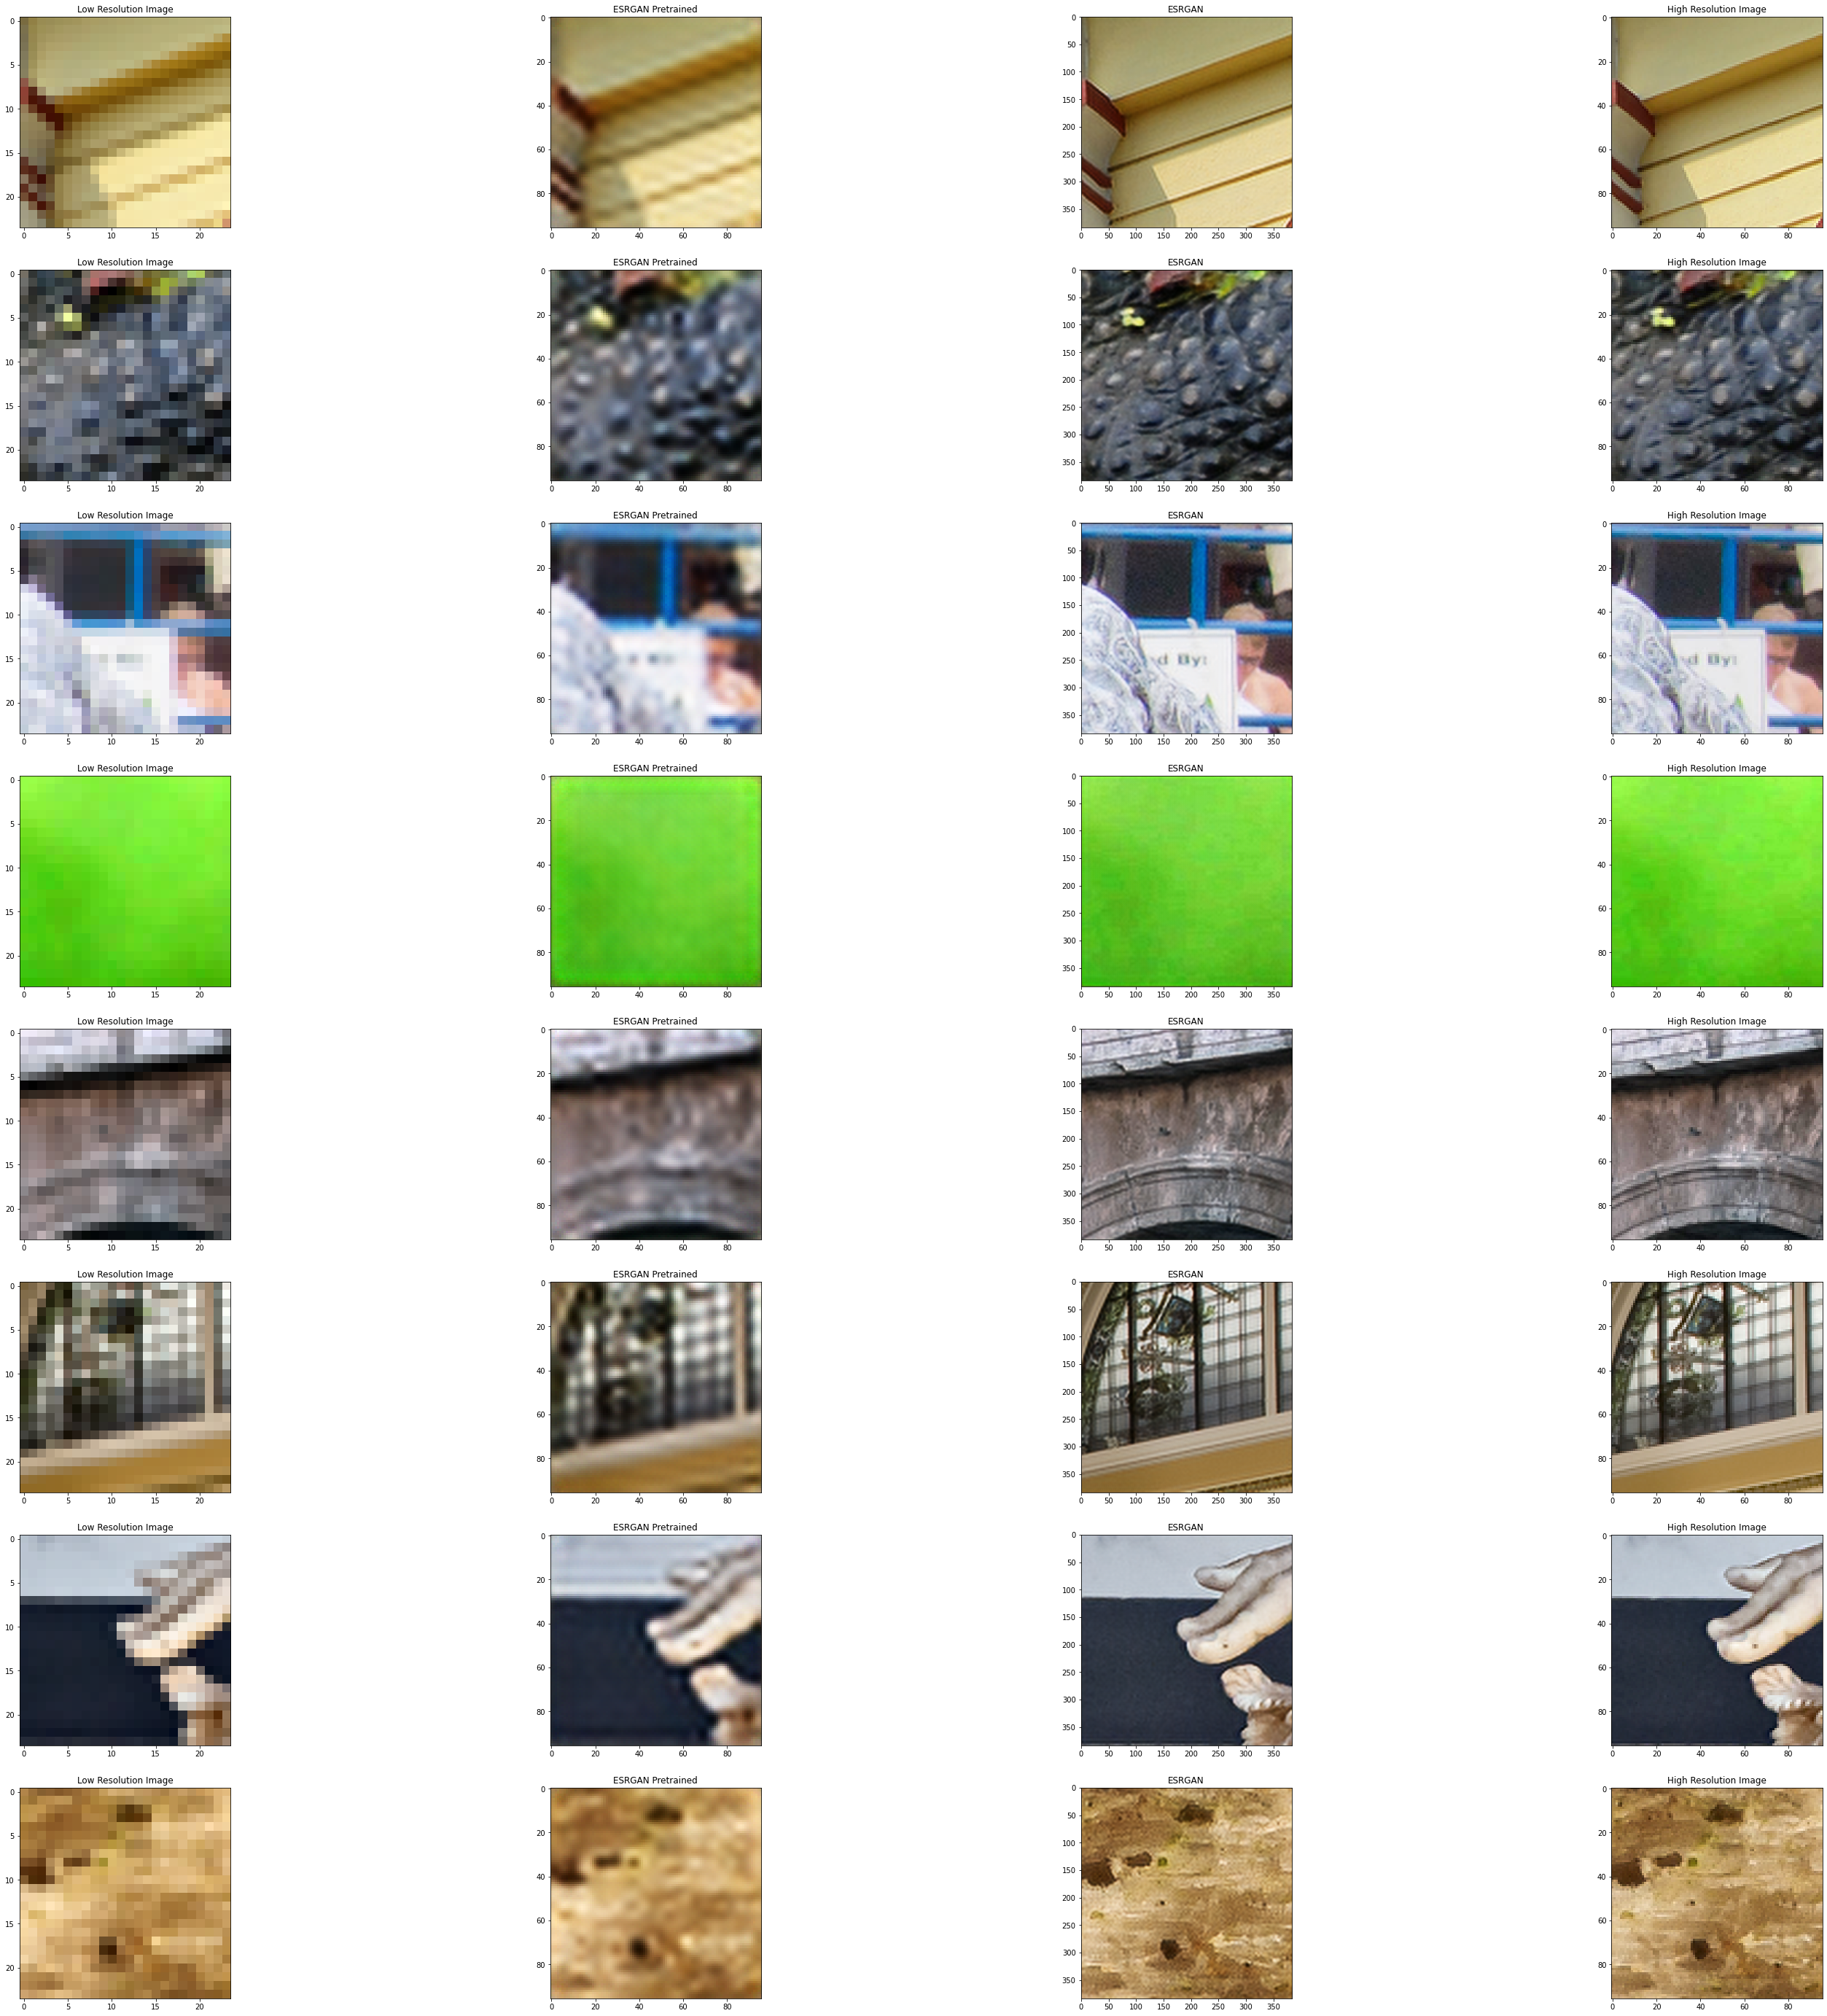

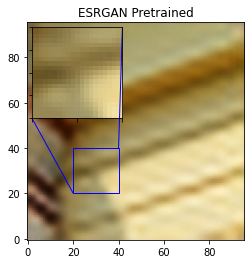

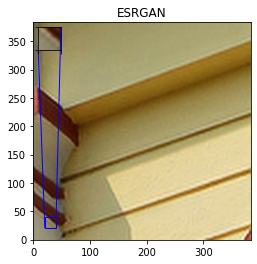

In [38]:
GRID_IMAGE_PATH = os.path.join(BASE_IMAGE_PATH, "grid.png")

print("[INFO] plotting the ESRGAN predictions...")
(fig, axes) = subplots(nrows=INFER_BATCH_SIZE, ncols=4,
	figsize=(50, 50))

for (ax, lowRes, esrPreIm, esrGanIm, highRes) in zip(axes, 
                                                     lr_image, esrgan_pre_gen_pred, 
                                                     esrgan_gen_pred, hr_image):

	ax[0].imshow(array_to_img(lowRes))
	ax[0].set_title("Low Resolution Image")
 
	ax[1].imshow(array_to_img(esrPreIm))
	ax[1].set_title("ESRGAN Pretrained")

	ax[2].imshow(array_to_img(esrGanIm))
	ax[2].set_title("ESRGAN")

	ax[3].imshow(array_to_img(highRes))
	ax[3].set_title("High Resolution Image")

if not os.path.exists(BASE_IMAGE_PATH):
	os.makedirs(BASE_IMAGE_PATH)

print("[INFO] saving the ESRGAN predictions to disk...")
fig.savefig(GRID_IMAGE_PATH)

zoom_into_images(esrgan_pre_gen_pred[0], "ESRGAN Pretrained")
zoom_into_images(esrgan_gen_pred[0], "ESRGAN")